# Prediction of protein subcellular localisation - Jorge Martínez (M2BI)

## Load modules

In [1]:
import numpy as np
from pandas import read_csv
import pandas as pd

# Tensorflow and keras import
from keras import layers, models, utils, callbacks, optimizers

# # Utils to manipulate data
from keras.utils import to_categorical

# # Keras models
from keras.models import Sequential, Model

# # Keras layers
from keras.layers import Dense, Dropout
from keras.layers import Add, Permute
from keras.layers import Activation, Input
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D, Concatenate
from keras.layers import Flatten

from scipy.ndimage import gaussian_filter1d
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

# # Callback (for learning/optimize)
from keras.callbacks import EarlyStopping

# # Data analysis and protocol
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


# # Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Load data and take a first look

In [44]:
# Load the data
train = np.load("../data/reduced_train.npz")
test = np.load("../data/reduced_val.npz")

# Create the x and y data for the train and test sets
x_train = train['X_train']
y_train = train['y_train']

x_test = test['X_val']
y_test = test['y_val']

# Basic Information
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

# Data Types
print("\nData types:")
print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Missing Values
print("\nMissing values in x_train:", np.isnan(x_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())

Shape of x_train: (2423, 400, 20)
Shape of y_train: (2423,)
Shape of x_test: (635, 400, 20)
Shape of y_test: (635,)

Data types:
x_train dtype: float32
y_train dtype: int32

Missing values in x_train: 0
Missing values in y_train: 0


In [45]:
# Sample Data
print("\nFirst 5 rows of x_train:")
print(x_train[:5])
print("\nFirst 5 rows of y_train:")
print(y_train[:5])


First 5 rows of x_train:
[[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0. 


Class distribution in y_train:
Class 0: 338 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 233 samples
Class 4: 285 samples
Class 5: 63 samples
Class 6: 224 samples
Class 7: 59 samples
Class 8: 60 samples
Class 9: 59 samples


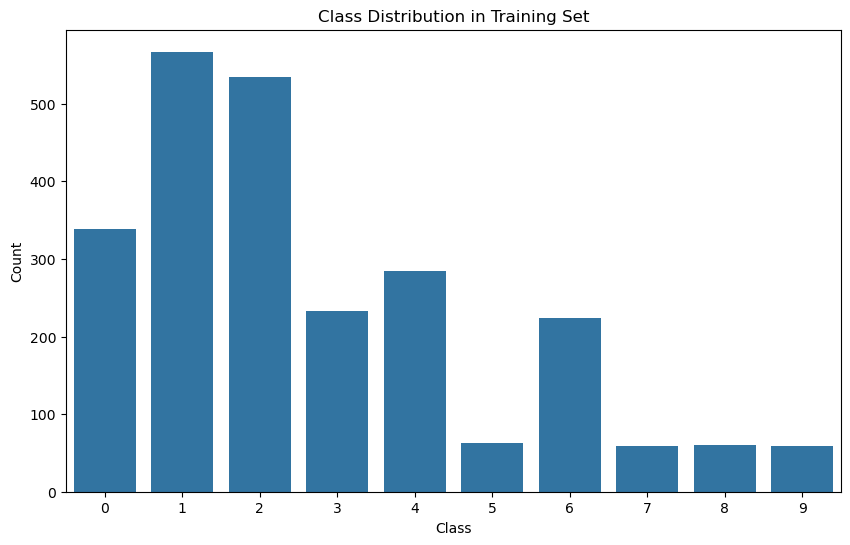

In [46]:
# Class Distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in y_train:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")
    
# Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [47]:
# One hot encoding
num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## DNN

In [6]:
def dnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# Create the model 
model_dnn = dnn_model()
model_dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       256,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,362 (1001.41 KB)

 Trainable params: 256,362 (1001.41 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)

history_dnn = model_dnn.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2243 - loss: 2.2221 - val_accuracy: 0.3258 - val_loss: 2.0791
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3341 - loss: 2.0128 - val_accuracy: 0.3876 - val_loss: 1.9339
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3901 - loss: 1.8485 - val_accuracy: 0.3897 - val_loss: 1.8422
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4598 - loss: 1.7079 - val_accuracy: 0.4598 - val_loss: 1.7632
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5073 - loss: 1.5895 - val_accuracy: 0.5216 - val_loss: 1.6878
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5567 - loss: 1.4736 - val_accuracy: 0.5567 - val_loss: 1.6152
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5874 - loss: 1.3749 - val_accuracy: 0.5526 - val_loss: 1.5726
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6264 - loss: 1.3122 - val_accuracy: 0.5938 - val_loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7388 - loss: 0.9217
Test accuracy: 0.7260


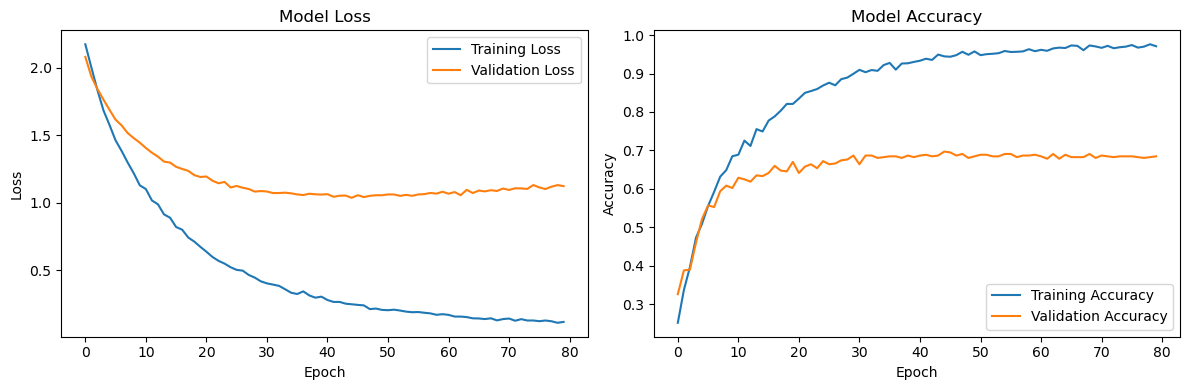

In [8]:
# Evaluate the model
test_loss_dnn, test_accuracy_dnn = model_dnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


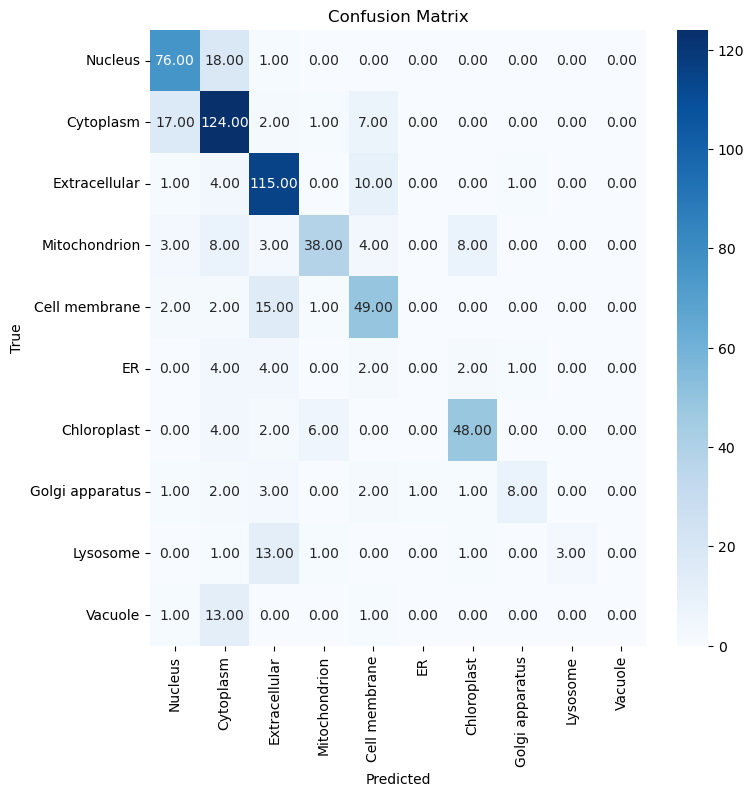

In [9]:
# Make predictions
y_pred = model_dnn.predict(x_test)


# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## CNN

In [10]:
def cnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Conv1D(32,
               kernel_size=3,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        
        Conv1D(64,
               kernel_size=5,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        Flatten(),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn = cnn_model()
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 400, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 200, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 100, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        64,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,650 (299.41 KB)

 Trainable params: 76,458 (298.66 KB)

 Non-trainable params: 192 (768.00 B)

In [11]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)   
history_cnn = model_cnn.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1880 - loss: 2.6379 - val_accuracy: 0.2268 - val_loss: 2.2431
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3249 - loss: 2.0695 - val_accuracy: 0.2268 - val_loss: 2.2443
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4036 - loss: 1.7983 - val_accuracy: 0.2371 - val_loss: 2.2526
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4940 - loss: 1.5494 - val_accuracy: 0.2433 - val_loss: 2.2323
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5267 - loss: 1.4450 - val_accuracy: 0.2392 - val_loss: 2.2656
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5788 - loss: 1.2212 - val_accuracy: 0.2371 - val_loss: 2.2627
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6500 - loss: 1.0610 - val_accuracy: 0.2103 - val_loss: 2.2669
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6838 - loss: 0.9331 - val_accuracy: 0.1856 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8147 - loss: 0.7280
Test accuracy: 0.8205


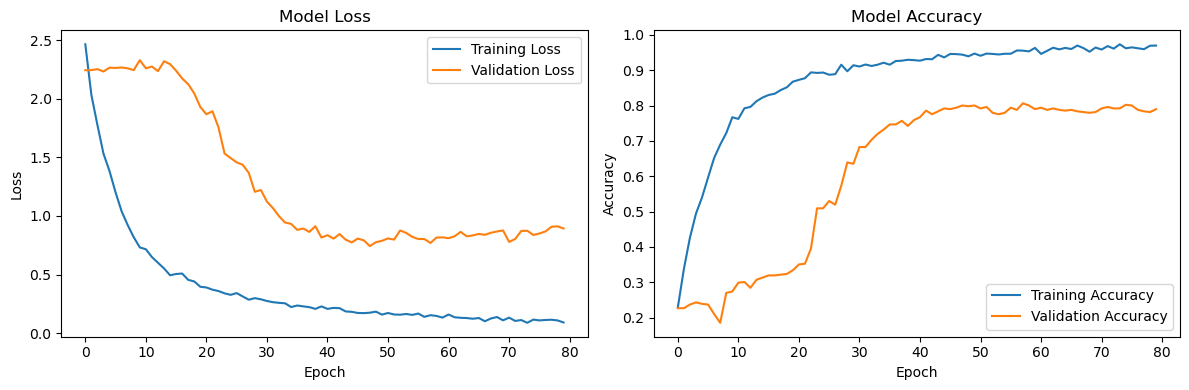

In [12]:
# Evaluate the model
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


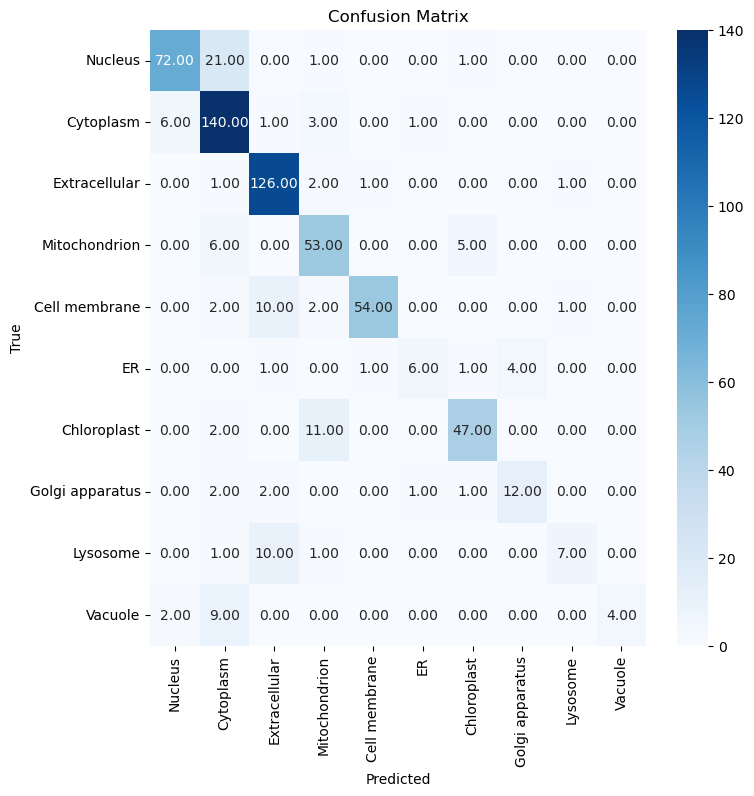

In [13]:
# Make predictions
y_pred = model_cnn.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## CNN - functional API

In [14]:
def cnn_api_model():
    inputs = Input(shape=(400,20))
    x = Permute((2,1))(inputs)
    
    # Make two parallel convolutional layers with different kernel sizes
    conv_1 = Conv1D(32,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(x)
    conv_2 = Conv1D(32,
                    kernel_size=5,
                    padding="same",
                    activation="relu")(x)
    
    convs = Concatenate(axis=1)([conv_1, conv_2])
    
    # Second simple convolutional layer
    conv_3 = Conv1D(64,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(convs)
    
    # Reduce dimensions
    max_pool = MaxPooling1D(pool_size = 5)(conv_3)
    
    # Flatten to apply a dense layer
    flat = Flatten()(max_pool)
    dense = Dense(32, activation="relu")(flat)
    drop = Dropout(0.5)(dense)
    
    # Output layer
    outputs = Dense(num_classes, activation="softmax")(drop)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn_api = cnn_api_model()
model_cnn_api.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 20, 400)   │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20, 32)    │     38,432 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20, 32)    │     64,032 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40, 32)    │          0 │ conv1d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 40, 64)    │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 8, 64)     │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 512)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     16,416 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │        330 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,418 (489.91 KB)

 Trainable params: 125,418 (489.91 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)   
history_cnn_api = model_cnn_api.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1585 - loss: 2.2399 - val_accuracy: 0.2289 - val_loss: 2.1049
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2286 - loss: 2.1262 - val_accuracy: 0.3216 - val_loss: 2.0593
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2470 - loss: 2.0712 - val_accuracy: 0.3175 - val_loss: 2.0187
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2727 - loss: 2.0255 - val_accuracy: 0.3196 - val_loss: 1.9713
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2910 - loss: 1.9857 - val_accuracy: 0.3196 - val_loss: 1.9343
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3324 - loss: 1.9114 - val_accuracy: 0.3237 - val_loss: 1.9131
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3290 - loss: 1.8896 - val_accuracy: 0.3237 - val_loss: 1.8813
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3510 - loss: 1.8189 - val_accuracy: 0.3258 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6961 - loss: 1.3496 
Test accuracy: 0.6913


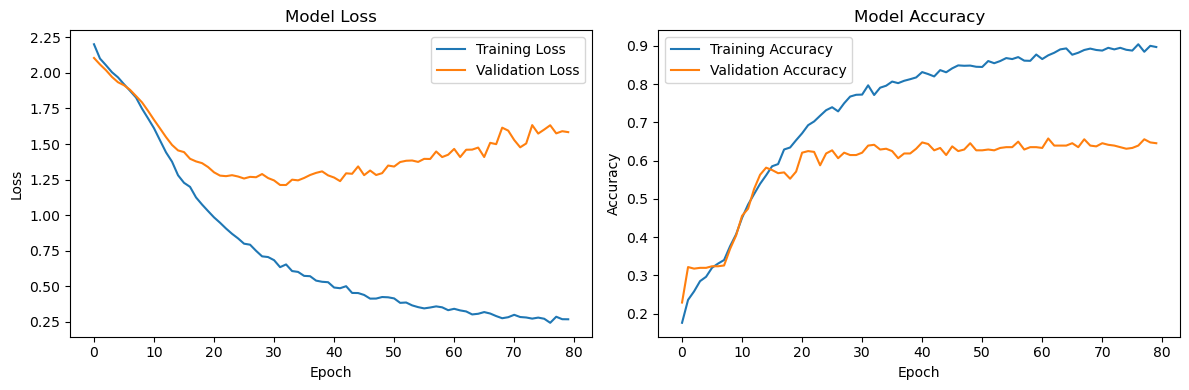

In [16]:
# Evaluate the model
test_loss_cnn_api, test_accuracy_cnn_api = model_cnn_api.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api.history['loss'], label='Training Loss')
plt.plot(history_cnn_api.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


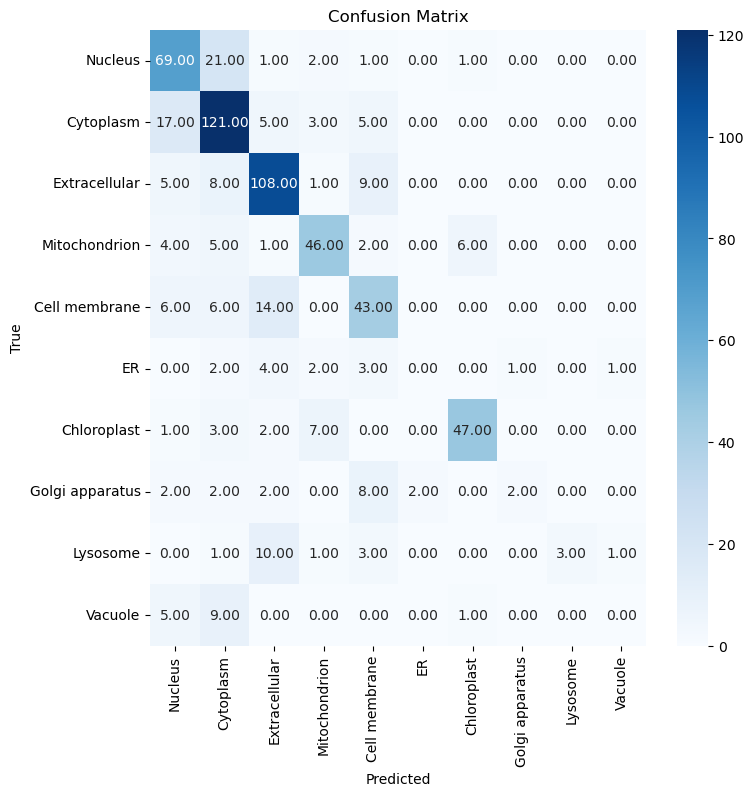

In [17]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## ResNet

In [48]:
# Define the residual block achitecture
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = 1)(x)
    
    # Second convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = kernel_size, 
               padding="same",
               strides = stride)(x)

    output = Add()([shortcut, x])
    return output

In [63]:
# Build the ResNet model
def resnet_model(input_shape=(400, 20), num_blocks=2):
    inputs = Input(shape=input_shape)
    
    residual_i = inputs
    
    for _ in range(num_blocks):
        residual_i = residual_block(residual_i, 20)
        
    gavg_1 = AveragePooling1D(2, strides=1)(residual_i)
    
    flat_1 = Flatten()(gavg_1)
    
    output = Dense(num_classes, activation="softmax")(flat_1)
    
    model = Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
                                                        
    return model

# Create the model
model_resnet = resnet_model()
model_resnet.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ input_layer_19[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 400, 20)   │        420 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_49[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 400, 20)   │      1,220 │ activation_35[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 400, 20)   │          0 │ input_layer_19[0… │
│                     │                   │            │ conv1d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add_17[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 400, 20)   │        420 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_51[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 400, 20)   │      1,220 │ activation_37[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 400, 20)   │          0 │ add_17[0][0],     │
│                     │                   │            │ conv1d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 399, 20)   │          0 │ add_18[0][0]      │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 7980)      │          0 │ average_pooling1… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 10)        │     79,810 │ flatten_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

In [64]:
history_resnet = model_resnet.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2509 - loss: 2.2685 - val_accuracy: 0.2619 - val_loss: 2.1703
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5750 - loss: 1.2969 - val_accuracy: 0.2309 - val_loss: 2.1317
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7234 - loss: 0.8831 - val_accuracy: 0.2289 - val_loss: 2.0925
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8235 - loss: 0.6177 - val_accuracy: 0.1876 - val_loss: 2.0586
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9083 - loss: 0.4262 - val_accuracy: 0.1897 - val_loss: 2.0288
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9325 - loss: 0.3300 - val_accuracy: 0.1835 - val_loss: 2.0540
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9550 - loss: 0.2468 - val_accuracy: 0.1814 - val_loss: 2.1036
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9820 - loss: 0.1843 - val_accuracy: 0.2021 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7290 - loss: 1.4317
Test accuracy: 0.7354


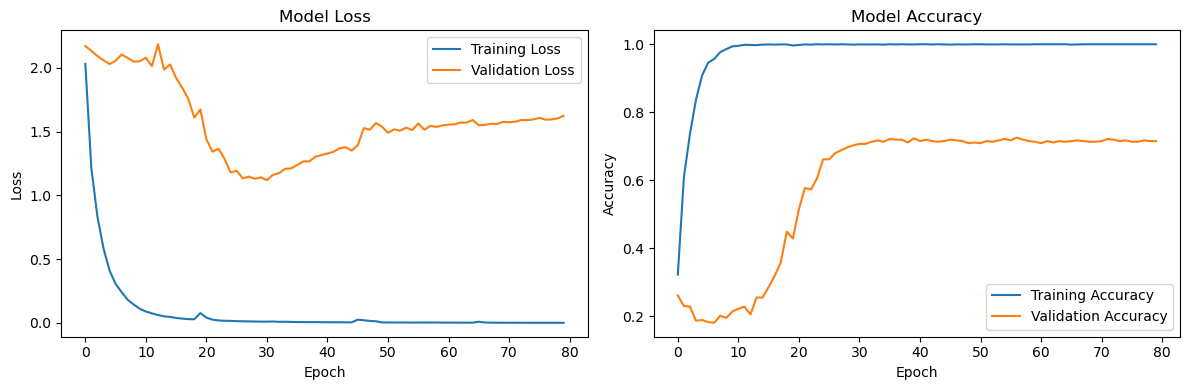

In [65]:
# Evaluate the model
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


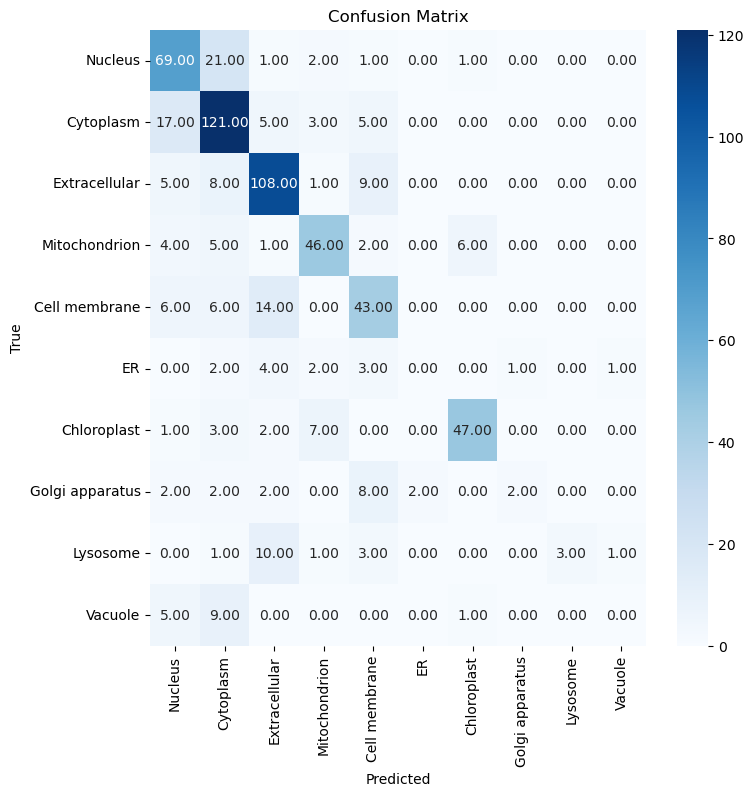

In [22]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Include class weights

In [23]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(np.argmax(y_train, axis=1)),
                                        y = np.argmax(y_train, axis=1)
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 0.7168639053254438, 1: 0.427336860670194, 2: 0.45289719626168223, 3: 1.0399141630901287, 4: 0.8501754385964913, 5: 3.846031746031746, 6: 1.0816964285714286, 7: 4.106779661016949, 8: 4.038333333333333, 9: 4.106779661016949}



### DNN

In [24]:
# Create the model 
model_dnn_cw = dnn_model()

history_dnn_cw = model_dnn_cw.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2,
                    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0607 - loss: 2.2857 - val_accuracy: 0.0784 - val_loss: 2.2930
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1545 - loss: 2.1151 - val_accuracy: 0.1340 - val_loss: 2.2544
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1806 - loss: 2.0991 - val_accuracy: 0.2577 - val_loss: 2.1788
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2713 - loss: 1.9315 - val_accuracy: 0.2474 - val_loss: 2.1429
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3008 - loss: 1.8211 - val_accuracy: 0.2619 - val_loss: 2.1007
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3226 - loss: 1.7225 - val_accuracy: 0.3691 - val_loss: 2.0180
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4023 - loss: 1.6049 - val_accuracy: 0.3876 - val_loss: 1.9594
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4632 - loss: 1.4377 - val_accuracy: 0.4289 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7450 - loss: 0.7763
Test accuracy: 0.7543


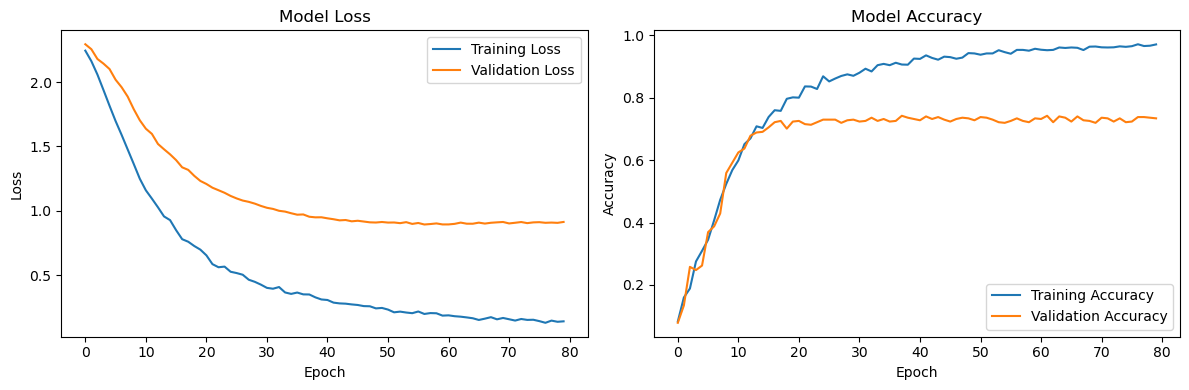

In [25]:
# Evaluate the model
test_loss_dnn_cw, test_accuracy_dnn_cw = model_dnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_cw.history['loss'], label='Training Loss')
plt.plot(history_dnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN

In [26]:
model_cnn_cw = cnn_model()

history_cnn_cw = model_cnn_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1479 - loss: 2.9538 - val_accuracy: 0.1485 - val_loss: 2.2962
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2639 - loss: 2.2786 - val_accuracy: 0.1155 - val_loss: 2.3477
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3059 - loss: 1.9974 - val_accuracy: 0.0577 - val_loss: 2.4327
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3400 - loss: 1.8827 - val_accuracy: 0.0227 - val_loss: 2.5181
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3956 - loss: 1.6680 - val_accuracy: 0.0289 - val_loss: 2.5603
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4360 - loss: 1.4291 - val_accuracy: 0.0227 - val_loss: 2.6232
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5087 - loss: 1.3319 - val_accuracy: 0.0227 - val_loss: 2.7217
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5647 - loss: 1.1908 - val_accuracy: 0.0268 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7935 - loss: 0.6755
Test accuracy: 0.8126


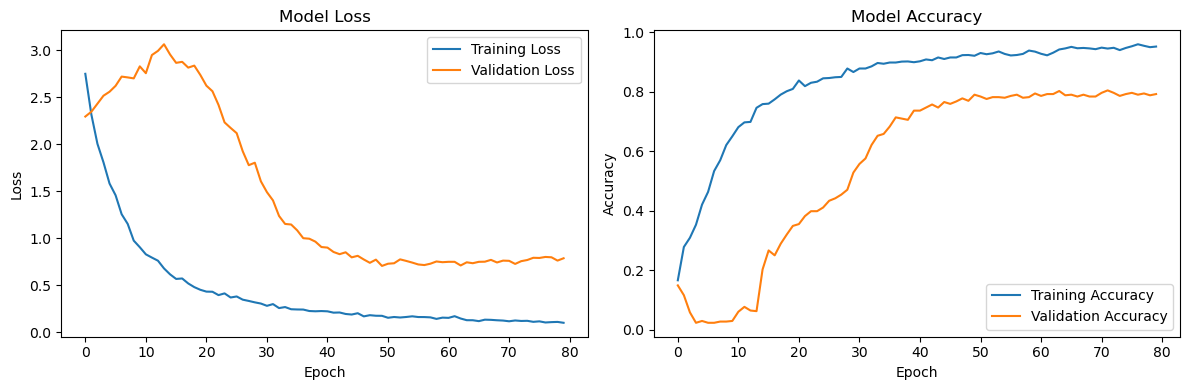

In [27]:
# Evaluate the model
test_loss_cnn_cw, test_accuracy_cnn_cw = model_cnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN - functional API

In [28]:
model_cnn_api_cw = cnn_api_model()
history_cnn_api_cw = model_cnn_api_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1200 - loss: 2.2001 - val_accuracy: 0.1402 - val_loss: 2.2869
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1623 - loss: 2.2635 - val_accuracy: 0.2144 - val_loss: 2.2573
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2126 - loss: 2.1786 - val_accuracy: 0.2680 - val_loss: 2.2180
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2247 - loss: 2.0830 - val_accuracy: 0.2536 - val_loss: 2.1896
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2530 - loss: 2.0744 - val_accuracy: 0.2804 - val_loss: 2.1510
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2605 - loss: 1.9947 - val_accuracy: 0.2639 - val_loss: 2.1590
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2797 - loss: 1.9925 - val_accuracy: 0.3299 - val_loss: 2.1090
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3031 - loss: 1.9671 - val_accuracy: 0.3196 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7089 - loss: 1.0713 
Test accuracy: 0.7039


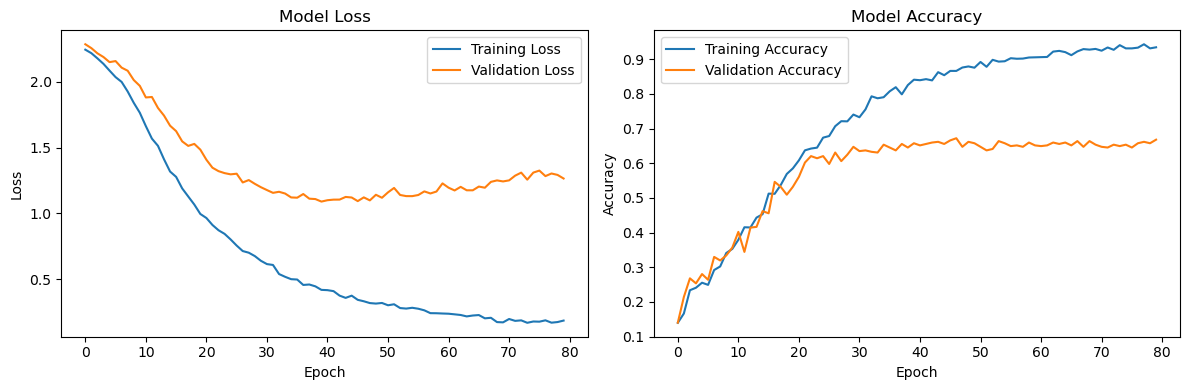

In [29]:
# Evaluate the model
test_loss_cnn_api_cw, test_accuracy_cnn_api_cw = model_cnn_api_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### ResNet

In [30]:
model_resnet_cw = resnet_model()
history_resnet_cw = model_resnet_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1806 - loss: 2.3169 - val_accuracy: 0.3567 - val_loss: 2.1827
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5198 - loss: 1.4404 - val_accuracy: 0.3361 - val_loss: 2.1091
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6832 - loss: 0.9980 - val_accuracy: 0.3299 - val_loss: 1.9974
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8265 - loss: 0.7136 - val_accuracy: 0.2845 - val_loss: 1.9318
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8867 - loss: 0.4793 - val_accuracy: 0.3031 - val_loss: 1.8947
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9097 - loss: 0.3495 - val_accuracy: 0.3031 - val_loss: 1.8707
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9353 - loss: 0.2680 - val_accuracy: 0.3258 - val_loss: 1.8355
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9481 - loss: 0.2091 - val_accuracy: 0.3340 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7464 - loss: 1.2180 
Test accuracy: 0.7465


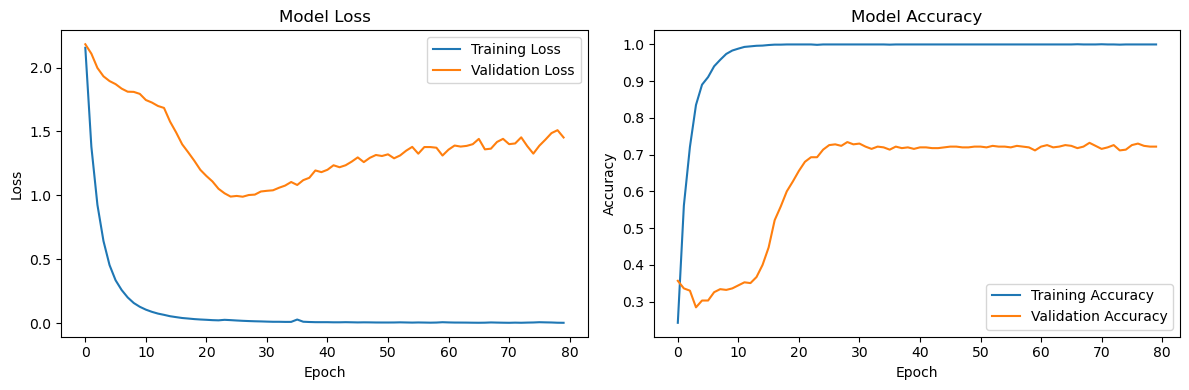

In [31]:
# Evaluate the model
test_loss_resnet_cw, test_accuracy_resnet_cw = model_resnet_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_cw.history['loss'], label='Training Loss')
plt.plot(history_resnet_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

# Data augmentation

In [32]:
def selective_masking(x, mask_prob=0.1):
    mask = np.random.random(x.shape) < mask_prob
    x_masked = x.copy()
    x_masked[mask] = 0
    return x_masked

def pssm_smoothing(x, sigma=1.0):
    return gaussian_filter1d(x, sigma=sigma, axis=0)

def substring_sampling(x, min_length=0.8):
    seq_length = x.shape[0]
    start = np.random.randint(0, int(seq_length * (1 - min_length)))
    end = start + int(seq_length * min_length) + np.random.randint(0, int(seq_length * (1 - min_length)))
    return x[start:end]

def augment_pssm_data(x_train, y_train, target_samples=500):
    class_counts = {label: np.sum(y_train == label) for label in np.unique(y_train)}
    
    x_aug, y_aug = [], []
    
    for class_label, count in class_counts.items():
        class_indices = np.where(y_train == class_label)[0]
        x_class = x_train[class_indices]
        
        if count < target_samples:
            augment_factor = int(np.ceil((target_samples - count) / count))
            
            for i in range(len(x_class)):
                # Original sequence
                x_aug.append(x_class[i])
                y_aug.append(class_label)
                
                # Augmented sequences
                for _ in range(augment_factor):
                    aug_seq = x_class[i].copy()
                    
                    # Apply augmentation techniques
                    aug_type = np.random.choice(['mask', 'smooth', 'substring'])
                    if aug_type == 'mask':
                        aug_seq = selective_masking(aug_seq)
                    elif aug_type == 'smooth':
                        aug_seq = pssm_smoothing(aug_seq)
                    elif aug_type == 'substring':
                        aug_seq = substring_sampling(aug_seq)
                    
                    x_aug.append(aug_seq)
                    y_aug.append(class_label)
        else:
            # For classes that already have enough samples, just add the original data
            x_aug.extend(x_class)
            y_aug.extend([class_label] * len(x_class))
    
    return x_aug, np.array(y_aug)

# Your existing data
x_train = train['X_train']
y_train = train['y_train']

# Augment the data
x_train_augmented, y_train_augmented = augment_pssm_data(x_train, y_train, target_samples=500)

# Pad sequences to the same length
max_length = max(seq.shape[0] for seq in x_train_augmented)
x_train_aug_padded = pad_sequences(x_train_augmented, maxlen=max_length, padding='post', dtype='float32')

# Shuffle the augmented dataset
indices = np.arange(len(x_train_aug_padded))
np.random.shuffle(indices)
x_train_aug = x_train_aug_padded[indices]
y_train_aug = y_train_augmented[indices]

# Class Distribution
unique, counts = np.unique(y_train_aug, return_counts=True)
print("\nClass distribution in y_train_aug:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

# Convert labels to categorical
num_classes = len(np.unique(y_train_aug))
y_train_aug = to_categorical(y_train_aug, num_classes)


Class distribution in y_train_aug:
Class 0: 676 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 699 samples
Class 4: 570 samples
Class 5: 504 samples
Class 6: 672 samples
Class 7: 531 samples
Class 8: 540 samples
Class 9: 531 samples


### DNN

In [33]:
# Create the model 
model_dnn_aug = dnn_model()

history_dnn_aug = model_dnn_aug.fit(x_train_aug, y_train_aug, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1279 - loss: 2.2684 - val_accuracy: 0.3185 - val_loss: 2.0777
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3297 - loss: 1.9920 - val_accuracy: 0.5562 - val_loss: 1.7902
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4874 - loss: 1.7056 - val_accuracy: 0.6661 - val_loss: 1.5551
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5752 - loss: 1.4872 - val_accuracy: 0.7193 - val_loss: 1.3727
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6459 - loss: 1.2863 - val_accuracy: 0.7442 - val_loss: 1.2408
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6874 - loss: 1.1560 - val_accuracy: 0.7631 - val_loss: 1.1284
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7351 - loss: 1.0298 - val_accuracy: 0.7768 - val_loss: 1.0394
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7641 - loss: 0.9455 - val_accuracy: 0.7888 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.7203 - loss: 1.1651
Test accuracy: 0.7433


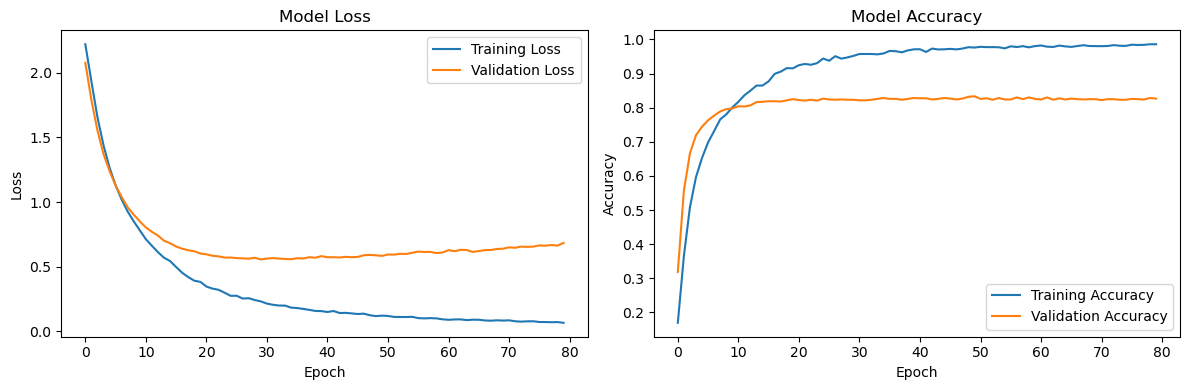

In [34]:
# Evaluate the model
test_loss_dnn_aug, test_accuracy_dnn_aug = model_dnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_aug.history['loss'], label='Training Loss')
plt.plot(history_dnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN

In [35]:
model_cnn_aug = cnn_model()

history_cnn_aug = model_cnn_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1649 - loss: 2.7311 - val_accuracy: 0.1176 - val_loss: 2.3021
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3304 - loss: 2.0173 - val_accuracy: 0.1433 - val_loss: 2.3977
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4624 - loss: 1.6519 - val_accuracy: 0.1923 - val_loss: 2.5989
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5600 - loss: 1.3083 - val_accuracy: 0.2292 - val_loss: 2.8297
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6372 - loss: 1.0966 - val_accuracy: 0.2524 - val_loss: 2.9213
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6493 - loss: 1.0262 - val_accuracy: 0.2584 - val_loss: 2.9553
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7158 - loss: 0.8818 - val_accuracy: 0.2258 - val_loss: 3.0762
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7277 - loss: 0.8078 - val_accuracy: 0.2275 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8326 - loss: 0.6653
Test accuracy: 0.8488


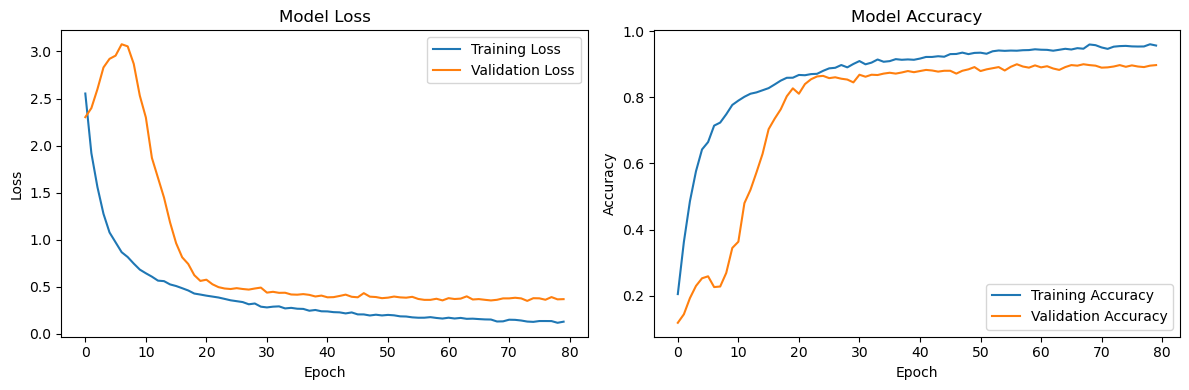

In [36]:
# Evaluate the model
test_loss_cnn_aug, test_accuracy_cnn_aug = model_cnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN - functional API

In [37]:
model_cnn_api_aug = cnn_api_model()
history_cnn_api_aug = model_cnn_api_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1235 - loss: 2.2920 - val_accuracy: 0.2670 - val_loss: 2.2380
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2003 - loss: 2.2226 - val_accuracy: 0.3356 - val_loss: 2.1407
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2524 - loss: 2.1266 - val_accuracy: 0.3760 - val_loss: 2.0059
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3225 - loss: 1.9741 - val_accuracy: 0.4609 - val_loss: 1.7937
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3914 - loss: 1.7792 - val_accuracy: 0.5451 - val_loss: 1.5871
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4507 - loss: 1.6119 - val_accuracy: 0.5785 - val_loss: 1.4294
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5188 - loss: 1.4520 - val_accuracy: 0.6438 - val_loss: 1.3171
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5597 - loss: 1.3480 - val_accuracy: 0.6635 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6795 - loss: 1.6459 
Test accuracy: 0.6992


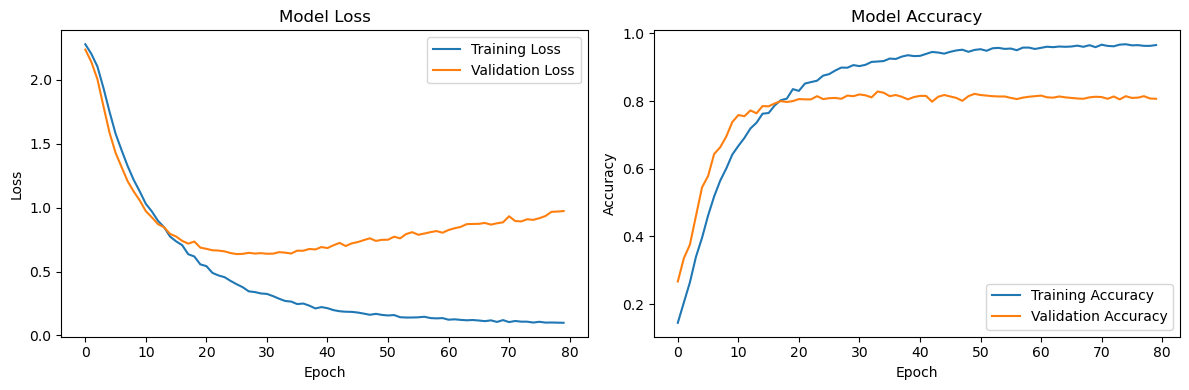

In [38]:
# Evaluate the model
test_loss_cnn_api_aug, test_accuracy_cnn_api_aug = model_cnn_api_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### ResNet

In [39]:
model_resnet_aug = resnet_model()
history_resnet_aug = model_resnet_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2751 - loss: 2.1682 - val_accuracy: 0.3142 - val_loss: 2.1475
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7110 - loss: 1.0238 - val_accuracy: 0.2352 - val_loss: 2.0800
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8373 - loss: 0.6414 - val_accuracy: 0.1717 - val_loss: 2.0704
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8912 - loss: 0.4636 - val_accuracy: 0.1914 - val_loss: 2.0210
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9248 - loss: 0.3426 - val_accuracy: 0.2489 - val_loss: 1.9937
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9565 - loss: 0.2557 - val_accuracy: 0.2876 - val_loss: 1.8483
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9674 - loss: 0.1937 - val_accuracy: 0.4386 - val_loss: 1.6342
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9820 - loss: 0.1524 - val_accuracy: 0.5099 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7287 - loss: 1.8340 
Test accuracy: 0.7354


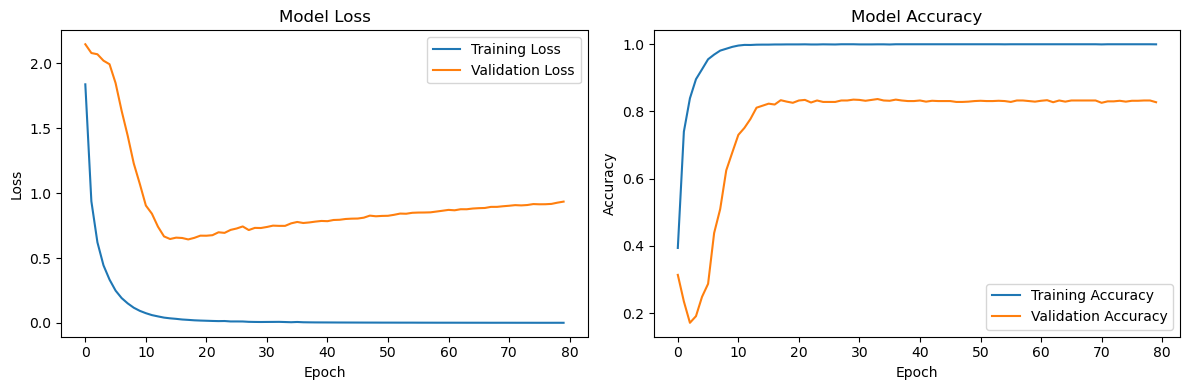

In [40]:
# Evaluate the model
test_loss_resnet_aug, test_accuracy_resnet_aug = model_resnet_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_aug.history['loss'], label='Training Loss')
plt.plot(history_resnet_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

# Comparison

Table of Accuracy Values:


Method,Base,CW,Aug
Model,,,
CNN,0.8205,0.8126,0.8488
CNN_API,0.6913,0.7039,0.6992
DNN,0.7260,0.7543,0.7433
ResNet,0.7339,0.7465,0.7354


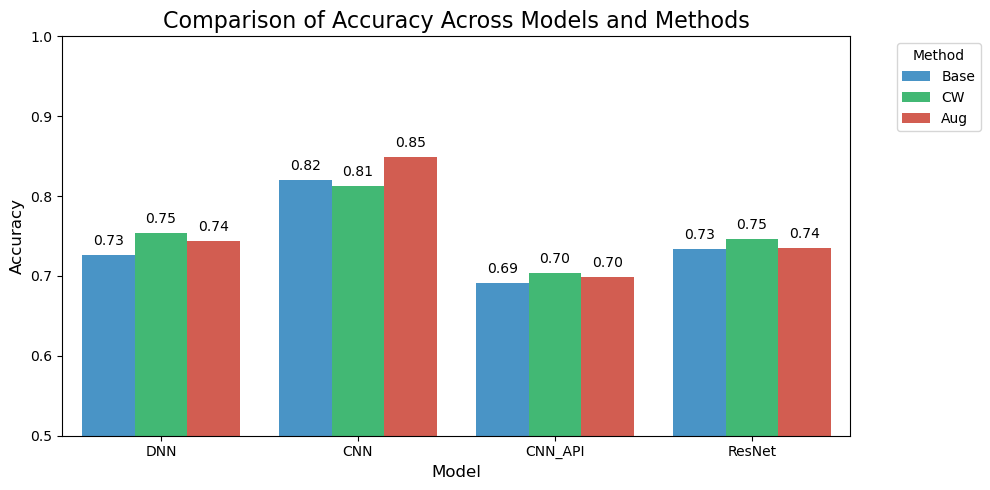

In [41]:
data = {
    'Model': ['DNN', 'DNN', 'DNN', 'CNN', 'CNN', 'CNN', 'CNN_API', 'CNN_API', 'CNN_API', 'ResNet', 'ResNet', 'ResNet'],
    'Method': ['Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug'],
    'Accuracy': [test_accuracy_dnn, test_accuracy_dnn_cw, test_accuracy_dnn_aug,
                 test_accuracy_cnn, test_accuracy_cnn_cw, test_accuracy_cnn_aug,
                 test_accuracy_cnn_api, test_accuracy_cnn_api_cw, test_accuracy_cnn_api_aug,
                 test_accuracy_resnet, test_accuracy_resnet_cw, test_accuracy_resnet_aug]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Pivot the table to get the desired format
pivot_df = df.pivot(index='Model', columns='Method', values='Accuracy')

# Reorder the columns
pivot_df = pivot_df[['Base', 'CW', 'Aug']]

# Display the table
print("Table of Accuracy Values:")
display(pivot_df.style.format("{:.4f}").highlight_max(axis=1))

# Function to add value labels on bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = f"{y_value:.2f}"
        
        ax.annotate(label, (x_value, y_value), xytext=(0, spacing),
                    textcoords="offset points", ha='center', va='bottom')

colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', hue='Method', data=df, palette=colors)
plt.title('Comparison of Accuracy Across Models and Methods', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.5, 1.0)  # Adjust this range based on your actual accuracy values
add_value_labels(ax)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()